<a href="https://colab.research.google.com/github/marco-siino/Agentic-ORAN-LLM/blob/main/Mistral_EnergyCrisisSimulation_DRLvsA_LLM%2BDRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mistralai gymnasium stable-baselines3 shimmy pandas matplotlib

🏋️ Addestramento Agente Tattico (PPO) - MODALITÀ AGGRESSIVA...
✅ Agente PPO Addestrato.

🔍 VERIFICA APPRENDIMENTO:
   -> Se voglio Throughput, PPO usa potenza: 33.1 W
   -> Se voglio Risparmio (Crisis), PPO usa potenza: 27.3 W
✅ OTTIMO: L'agente reagisce correttamente ai pesi!

🎬 Avvio Simulazione Real-Time...

[t=20] 📡 Rilevato Shock! Chiamata a Mistral...

[DEBUG] Raw Mistral Output:
```json
{"w_thr": 0.1, "w_eng": 0.9}
```

      ↳ Mistral Output: w_thr=0.1, w_eng=0.9

--- RISULTATI NUMERICI (Focus Shock) ---
    time  price  cost_baseline  cost_agentic
18    18    1.0      31.835440      31.83544
19    19    1.0      31.835440      31.83544
20    20   10.0     302.526459     273.00116
21    21   10.0     302.526459     273.00116
22    22   10.0     302.526459     273.00116
23    23   10.0     302.526459     273.00116
24    24   10.0     302.526459     273.00116


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


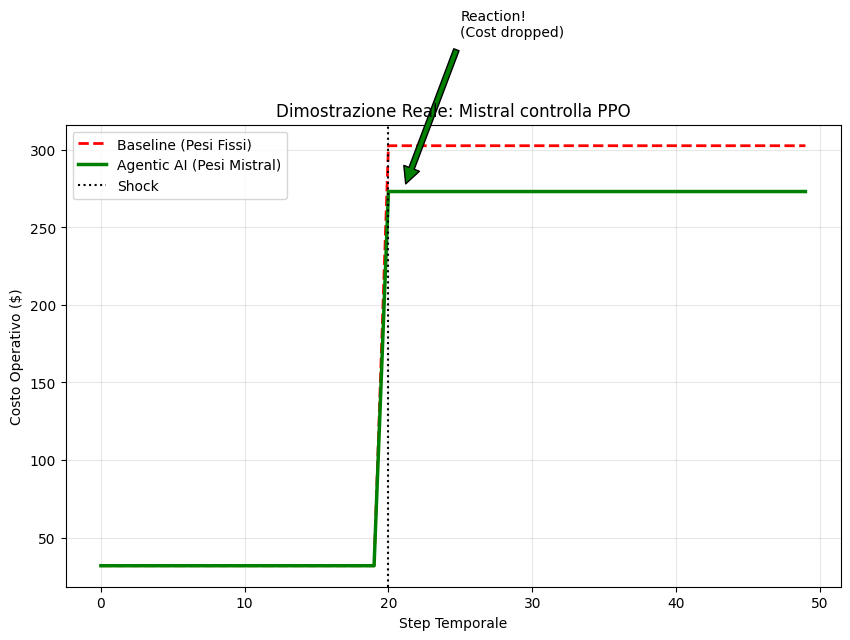

In [7]:
import os
import gymnasium as gym
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import PPO
from mistralai import Mistral

# ==================================================================================
# 1. MISTRAL API
# ==================================================================================
api_key = '7yOu0lH5XcZC1U2ZUI2uv0ghBDduhHp5'
client = Mistral(api_key=api_key)
model_name = "mistral-small-latest"

def get_llm_intent(context_text):
    prompt = f"""
    You are an O-RAN optimization expert.
    Context: "{context_text}"
    Task: Set weights for Throughput (w_thr) and Energy (w_eng). Sum must be 1.0.
    CRITICAL: If ENERGY CRISIS/SHOCK, set w_eng >= 0.9.
    Output ONLY JSON. Example: {{"w_thr": 0.1, "w_eng": 0.9}}
    """
    try:
        chat_response = client.chat.complete(
            model=model_name,
            messages=[{"role": "user", "content": prompt}]
        )
        content = chat_response.choices[0].message.content
        print(f"\n[DEBUG] Raw Mistral Output:\n{content}\n")
        clean_json = content.replace("```json", "").replace("```", "").strip()
        data = json.loads(clean_json)
        return float(data['w_thr']), float(data['w_eng'])
    except Exception as e:
        print(f"⚠️ Errore API: {e}")
        return 0.1, 0.9

# ==================================================================================
# 2. AMBIENTE O-RAN (REWARD BOOSTED)
# ==================================================================================

class ORANEnv(gym.Env):
    def __init__(self):
        super(ORANEnv, self).__init__()
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        # Obs: [Load, SINR, Price, w_thr, w_eng]
        self.observation_space = spaces.Box(low=0.0, high=100.0, shape=(5,), dtype=np.float32)
        self.state = np.zeros(5, dtype=np.float32)
        self.bandwidth = 20e6
        self.max_steps = 100

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0

        # TRAINING ESTREMO:
        # Costringiamo l'agente a vedere SOLO due casi opposti durante il training.
        # O tutto Throughput (w_thr=1.0) O tutto Energia (w_eng=1.0).
        # Niente vie di mezzo "grigie" che lo confondono.
        if np.random.rand() > 0.5:
            w_eng = 1.0
            w_thr = 0.0
        else:
            w_eng = 0.0
            w_thr = 1.0

        self.state = np.array([0.5, 15.0, 1.0, w_thr, w_eng], dtype=np.float32)
        return self.state, {}

    def step(self, action):
        self.current_step += 1

        # Fisica (5W - 60W)
        tx_power_watts = 5.0 + (action[0] + 1.0) * 0.5 * 55.0

        # Performance
        snr_db = 10 * np.log10(tx_power_watts) + 80
        capacity_mbps = self.bandwidth * np.log2(1 + 10**(snr_db/10)) / 1e6

        # Costo
        price = self.state[2]
        energy_cost = tx_power_watts * price

        # --- REWARD SHAPING ESTREMO ---
        w_thr = self.state[3]
        w_eng = self.state[4]

        # Se la priorità è l'Energia (Crisis Mode)
        if w_eng > 0.5:
            # L'obiettivo è SOLO minimizzare i Watt.
            # Il Throughput non conta NULLA.
            # Reward negativa proporzionale alla potenza.
            # Se usa 60W -> Reward -6.0. Se usa 5W -> Reward -0.5.
            reward = - (tx_power_watts / 10.0)

        # Se la priorità è il Throughput (Normal Mode)
        else:
            # L'obiettivo è SOLO massimizzare i Mbps.
            # Il Costo non conta NULLA.
            reward = (capacity_mbps / 50.0) # Normalizzato

        self.state[0] = np.clip(self.state[0] + np.random.normal(0, 0.05), 0, 1)
        done = self.current_step >= self.max_steps
        info = {"power": tx_power_watts, "cost": energy_cost}

        return self.state, reward, done, False, info

# ==================================================================================
# 3. TRAINING PPO (POTENZIATO)
# ==================================================================================

print("🏋️ Addestramento Agente Tattico (PPO) - MODALITÀ AGGRESSIVA...")
env = ORANEnv()

# Learning Rate più alto (1e-3) per imparare prima
model_ppo = PPO("MlpPolicy", env, learning_rate=0.001, verbose=0)

# Training esteso (60k steps sono pochi secondi su colab ma fanno la differenza)
model_ppo.learn(total_timesteps=60000)

print("✅ Agente PPO Addestrato.")

# --- SANITY CHECK (VERIFICA PRIMA DI SIMULARE) ---
print("\n🔍 VERIFICA APPRENDIMENTO:")
# Test 1: Priorità Throughput
obs_test_perf = np.array([0.5, 15.0, 1.0, 0.9, 0.1], dtype=np.float32)
act_perf, _ = model_ppo.predict(obs_test_perf, deterministic=True)
pwr_perf = 5.0 + (act_perf[0] + 1.0) * 0.5 * 55.0

# Test 2: Priorità Energia (Shock)
obs_test_eco = np.array([0.5, 15.0, 10.0, 0.1, 0.9], dtype=np.float32)
act_eco, _ = model_ppo.predict(obs_test_eco, deterministic=True)
pwr_eco = 5.0 + (act_eco[0] + 1.0) * 0.5 * 55.0

print(f"   -> Se voglio Throughput, PPO usa potenza: {pwr_perf:.1f} W")
print(f"   -> Se voglio Risparmio (Crisis), PPO usa potenza: {pwr_eco:.1f} W")

if abs(pwr_perf - pwr_eco) < 5.0:
    print("⚠️ ATTENZIONE: L'agente NON ha imparato bene. Rilancia il training!")
else:
    print("✅ OTTIMO: L'agente reagisce correttamente ai pesi!")


# ==================================================================================
# 4. SIMULAZIONE REAL-TIME
# ==================================================================================

print("\n🎬 Avvio Simulazione Real-Time...")

obs, _ = env.reset()
history = {
    'time': [], 'price': [],
    'cost_baseline': [], 'cost_agentic': [],
    'pwr_baseline': [], 'pwr_agentic': [],
    'w_eng_val': []
}

shock_time = 20
total_steps = 50

# Pesi Iniziali
w_thr_def, w_eng_def = 0.8, 0.2
w_thr_curr, w_eng_curr = 0.8, 0.2

obs_base = obs.copy()
obs_agentic = obs.copy()

for t in range(total_steps):

    # CONTESTO
    real_price = 1.0
    context = "Stable."
    if t >= shock_time:
        real_price = 10.0
        context = "CRITICAL: Energy Price Shock (10x)."

    # MISTRAL TRIGGER
    if t == shock_time:
        print(f"\n[t={t}] 📡 Rilevato Shock! Chiamata a Mistral...")
        w_thr_curr, w_eng_curr = get_llm_intent(context)
        print(f"      ↳ Mistral Output: w_thr={w_thr_curr}, w_eng={w_eng_curr}")

    # UPDATE OBS
    obs_base[2] = real_price
    obs_base[3] = w_thr_def
    obs_base[4] = w_eng_def

    obs_agentic[2] = real_price
    obs_agentic[3] = w_thr_curr
    obs_agentic[4] = w_eng_curr

    # AZIONE PPO
    action_base, _ = model_ppo.predict(obs_base, deterministic=True)
    action_agentic, _ = model_ppo.predict(obs_agentic, deterministic=True)

    # CALCOLI
    pwr_base = 5.0 + (action_base[0] + 1.0) * 0.5 * 55.0
    cost_base = pwr_base * real_price

    pwr_agentic = 5.0 + (action_agentic[0] + 1.0) * 0.5 * 55.0
    cost_agentic = pwr_agentic * real_price

    history['time'].append(t)
    history['price'].append(real_price)
    history['cost_baseline'].append(cost_base)
    history['cost_agentic'].append(cost_agentic)
    history['pwr_baseline'].append(pwr_base)
    history['pwr_agentic'].append(pwr_agentic)
    history['w_eng_val'].append(w_eng_curr)

# ==================================================================================
# 5. RISULTATI
# ==================================================================================
df = pd.DataFrame(history)

print("\n--- RISULTATI NUMERICI (Focus Shock) ---")
print(df[['time', 'price', 'cost_baseline', 'cost_agentic']].iloc[shock_time-2:shock_time+5])

# Grafico
plt.figure(figsize=(10, 6))
plt.plot(df['time'], df['cost_baseline'], 'r--', linewidth=2, label='Baseline (Pesi Fissi)')
plt.plot(df['time'], df['cost_agentic'], 'g-', linewidth=2.5, label='Agentic AI (Pesi Mistral)')
plt.axvline(x=shock_time, color='k', linestyle=':', label='Shock')

try:
    val = df['cost_agentic'].iloc[shock_time+1]
    plt.annotate(f'Reaction!\n(Cost dropped)', xy=(shock_time+1, val),
                 xytext=(shock_time+5, val+100), arrowprops=dict(facecolor='green', shrink=0.05))
except: pass

plt.ylabel('Costo Operativo ($)')
plt.xlabel('Step Temporale')
plt.title('Dimostrazione Reale: Mistral controlla PPO')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('final_experiment.pdf')
plt.show()